In [ ]:
#miss forest doesn't work for current version of sklearn
#if necessary, downgrade sklearn version
#https://github.com/scikit-learn/scikit-learn/discussions/25745

#pip uninstall scikit-learn -y
#pip install scikit-learn==1.1.2

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#ignores future warnings for miss forest

In [2]:
import pandas as pd
import openpyxl   #to read in a sheet of the excel file

#imputation libraries  (import sklearn before importing sys and missingpy otherwise an error will happen)
import sklearn


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [5]:
#imputation libraries (read this, then the cell below, then this cell again)
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [6]:
#imputation libraries
from missingpy import MissForest

### Manipulate dataframe

Data can be downloaded for the plasma proteomic dataset from the following paper: <br>
Multi-Omics Resolves a Sharp Disease-State Shift between Mild and Moderate COVID-19 (Su et al., 2020)

In [ ]:
data = pd.read_excel('Data/Su_raw.xlsx', sheet_name=3)

controls = data.loc[data['Group'] == 'Healthy Donor ']
cases = data.loc[data['Group'] == 'COVID19 ']

#There are two readings for each patient e.g. INCOV051-BL and INCOV051-AC
#BL stands for the first draw (this is the one we want); AC is the second draw and can be filtered out
first_draws = cases[cases.loc[:,'sample_id'].str.contains("BL")]
first_draws.loc[:,'sample_id'] = first_draws.loc[:,'sample_id'].str.rstrip('-BL')  #remove 'BL' label from the cases (so I can match to WHO status)

df = pd.concat([controls, first_draws], ignore_index=True)  #concatenate dataset and reset index 
df.insert(0, "WHO_status", '0') #insert new column for WHO_status and temporarily add all zeros

#display(df['sample_id'][124:130])    #first instance of a case is at index 124
#display(df)


In [8]:
#Read in WHO status data
who_data = pd.read_excel('Data/Su_raw.xlsx', sheet_name=1)

#Subset to only first draw readings
who_data = who_data[who_data["Sample ID"].str.contains("-1")]
who_data = who_data.reset_index(drop=True) #Reset index and drop old index
display(who_data)


#Create a dictionary with the sample names as a key and WHO status as a value
who_dict = {}

for i in range(0,len(who_data.index)):
    who = who_data["Who Ordinal Scale"][i]
    if who == 1 or who == 2 or who == "1 or 2":
        who = '1-2'
    elif who == 3 or who == 4:
        who = '3-4'
    elif who == 5 or who == 6 or who == 7:
        who = '5-7'
    else:
        print(who)
        who = "ERROR"

    sample = who_data["Study Subject ID"][i]
    who_dict[sample] = who



print(who_dict)

,Study Subject ID,Sample ID,Blood draw time point,Patient Location,Who Ordinal Scale,Sex,Age,Ethnicity,Race,BMI,...,Respiratory Support,Temperature,Systolic BP,Diastolic BP,10X?,Metabolomics,Proteomics?,Isoplexis CD8 assay?,Isoplexis CD4 assay?,Isoplexis Monocyte assay?
0,INCOV001,INCOV001-1,T1,Hospital,3,Female,77,NOT Hispanic or Latino,White,33.657783,...,None,36.6,139.0,60.0,yes,yes,yes,yes,yes,yes
1,INCOV002,INCOV002-1,T1,ICU,5,Male,39,NOT Hispanic or Latino,White,27.900747,...,High flow nasal cannula (HFNC),37.3,96.0,57.0,yes,yes,yes,yes,yes,yes
2,INCOV003,INCOV003-1,T1,ICU,7,Male,64,NOT Hispanic or Latino,White,24.546988,...,Other,37.2,89.0,50.0,yes,yes,yes,yes,yes,yes
3,INCOV004,INCOV004-1,T1,Hospital,4,Male,76,NOT Hispanic or Latino,White,23.477620,...,Nasal cannula,36.2,137.0,64.0,yes,yes,yes,yes,yes,yes
4,INCOV005,INCOV005-1,T1,Hospital,4,Male,75,NOT Hispanic or Latino,White,29.703121,...,Nasal cannula,36.8,126.0,105.0,yes,yes,yes,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,INCOV141,INCOV141-1,T1,Home (mobile phlebotomy),1,Male,31,NOT Hispanic or Latino,White,26.575066,...,None,NaN,NaN,NaN,yes,no,yes,no,no,no
135,INCOV142,INCOV142-1,T1,ICU,5,Male,64,NOT Hispanic or Latino,Asian,30.980420,...,High flow nasal cannula (HFNC),36.2,104.0,45.0,yes,yes,yes,no,no,no
136,INCOV144,INCOV144-1,T1,Home (mobile phlebotomy),1 or 2,Female,67,NOT Hispanic or Latino,White,NaN,...,None,NaN,NaN,NaN,yes,no,yes,no,no,no
137,INCOV145,INCOV145-1,T1,Hospital,4,Male,55,NOT Hispanic or Latino,White,35.871500,...,Nasal cannula,36.9,148.0,85.0,yes,no,yes,no,no,no


{'INCOV001': '3-4', 'INCOV002': '5-7', 'INCOV003': '5-7', 'INCOV004': '3-4', 'INCOV005': '3-4', 'INCOV006': '3-4', 'INCOV007': '3-4', 'INCOV008': '5-7', 'INCOV009': '3-4', 'INCOV010': '3-4', 'INCOV011': '3-4', 'INCOV012': '3-4', 'INCOV013': '5-7', 'INCOV014': '3-4', 'INCOV015': '3-4', 'INCOV016': '3-4', 'INCOV017': '3-4', 'INCOV018': '3-4', 'INCOV019': '3-4', 'INCOV020': '5-7', 'INCOV021': '3-4', 'INCOV022': '5-7', 'INCOV023': '3-4', 'INCOV024': '3-4', 'INCOV025': '5-7', 'INCOV026': '5-7', 'INCOV027': '3-4', 'INCOV028': '3-4', 'INCOV029': '5-7', 'INCOV030': '3-4', 'INCOV031': '5-7', 'INCOV032': '5-7', 'INCOV033': '5-7', 'INCOV034': '3-4', 'INCOV035': '5-7', 'INCOV036': '5-7', 'INCOV037': '3-4', 'INCOV038': '3-4', 'INCOV039': '1-2', 'INCOV040': '3-4', 'INCOV041': '5-7', 'INCOV042': '1-2', 'INCOV043': '3-4', 'INCOV044': '3-4', 'INCOV045': '3-4', 'INCOV047': '5-7', 'INCOV048': '5-7', 'INCOV049': '3-4', 'INCOV050': '3-4', 'INCOV051': '5-7', 'INCOV052': '3-4', 'INCOV053': '3-4', 'INCOV054':

In [9]:
#Add WHO data into the original dataframe
for i in range(124,len(df.index)): #first instance of a case is at index 124
    sample = df.loc[i,"sample_id"]
    if sample in who_dict:
        df.loc[i,"WHO_status"] = who_dict[sample]

display(df)

,WHO_status,Group,sample_id,"lectin, galactoside-binding, soluble, 9","tumor necrosis factor receptor superfamily, member 10a",agouti related protein homolog (mouse),"tumor necrosis factor receptor superfamily, member 10b","tumor necrosis factor receptor superfamily, member 13B",c-fos induced growth factor (vascular endothelial growth factor D),dickkopf WNT signaling pathway inhibitor 1,...,"EGF-like-domain, multiple 7",REST corepressor 1,carbonic anhydrase XIV,syntaxin 8,"protein kinase, AMP-activated, beta 1 non-catalytic subunit",mitogen-activated protein kinase kinase kinase kinase 5,negative regulator of ubiquitin-like proteins 1,ectonucleoside triphosphate diphosphohydrolase 2,"melanoma antigen family D, 1",G protein-coupled receptor 56
0,0,Healthy Donor,1010823,9.467005,3.150612,4.765860,5.853070,9.776093,8.076783,10.286002,...,5.089420,1.904315,2.354585,3.370510,1.457120,6.393335,1.888595,1.272365,-1.015575,1.774740
1,0,Healthy Donor,1027114,2.414755,1.457353,1.244160,0.712265,2.301213,0.910362,-0.073302,...,5.737120,1.706265,2.174810,2.320480,0.754500,3.058775,0.745930,1.413305,-1.683045,1.542735
2,0,Healthy Donor,1029090,9.581175,3.121713,4.649250,5.796290,9.494383,8.618412,9.356512,...,5.046855,1.923825,2.362200,3.534835,1.649450,5.595935,2.099020,1.539440,-0.599360,1.543860
3,0,Healthy Donor,1049423,9.391395,3.068790,4.669920,5.773255,11.887820,7.702655,9.278815,...,4.665445,1.910215,2.364895,3.594625,1.468635,5.781550,1.864265,1.657420,-0.094040,1.229660
4,0,Healthy Donor,1057525,9.142025,3.198663,5.430080,5.614800,9.746692,8.250982,9.407002,...,5.510625,1.770395,2.533960,3.393515,1.293010,5.925985,1.124380,1.383710,-0.680310,1.763090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,3-4,COVID19,INCOV139,9.786717,3.699688,4.876522,6.064768,9.259790,7.528678,11.526053,...,6.731739,5.465761,2.660046,6.218315,4.499703,9.236677,5.852625,1.008050,1.686931,1.697320
255,1-2,COVID19,INCOV141,10.382318,3.511383,4.385330,5.207974,9.330641,7.803160,10.952554,...,6.131039,3.616375,3.294628,5.700506,3.362275,8.424453,4.588876,1.053973,0.996480,1.344471
256,5-7,COVID19,INCOV142,10.908705,4.361646,5.858950,6.801220,10.706707,6.956506,11.226867,...,6.102758,3.627333,1.468618,4.953478,3.224846,8.259428,3.961976,0.972515,0.772288,3.442974
257,1-2,COVID19,INCOV144,9.624015,3.330472,4.729950,4.996068,9.785855,7.849917,10.436921,...,5.427625,2.387093,1.869467,5.393703,3.315091,8.689472,3.920355,1.406586,0.873741,1.418509


In [10]:
#Make a different dataframe containing the meta data only (this will be changed later when samples are removed)
df.set_index('sample_id', inplace=True)
df.columns.values.tolist()

meta_data = df.iloc[:,[0,1]]
display(meta_data)

,WHO_status,Group
sample_id,,
1010823,0,Healthy Donor
1027114,0,Healthy Donor
1029090,0,Healthy Donor
1049423,0,Healthy Donor
1057525,0,Healthy Donor
...,...,...
INCOV139,3-4,COVID19
INCOV141,1-2,COVID19
INCOV142,5-7,COVID19


In [12]:
df_num  = df.iloc[:,2:] #all rows, all columns apart from the first two which is meta data

#Percentage of missing data in dataframe
missing_vals = df_num.isna().sum().sum()
print((missing_vals/(259*464))*100)


1.5502263347090932


In [20]:
#Identify which columns have missing data
#print(df_num.isna().any()[lambda x: x])

#Remove features with >40% missing data - same as Sara's thesis
df_filter = df_num.loc[:, df_num.isin([' ', np.nan, 0]).mean() <= 0.4]    #keep all rows, if columns have ' ' or nan or 0, count as though missing and take as TRUE, get the mean of all the TRUE values
print(df_filter.isna().any()[lambda x: x]) #Identify which columns still have missing data


interleukin 24                                             True
sprouty homolog 2 (Drosophila)                             True
protein phosphatase 1, regulatory (inhibitor) subunit 2    True
clusterin-like 1 (retinal)                                 True
dtype: bool


In [23]:

#Identify which rows have missing data
#print(df_filter[df_filter.isna().any(axis=1)])

#identify which ROWS have missing values for each sample
df_missing_row = df_filter[df_filter.isna().any(axis=1)]
for index, row in df_missing_row.iterrows():
    for column in df_missing_row.columns:
        if pd.isnull(row[column]):
            print(index,column)

#Remove samples with >50% missing data - same as Sara's thesis (none of the samples were removed)
df_filter = df_filter.loc[df_filter.isin([' ', np.nan, 0]).mean(axis=1) <= 0.01,:]    

missing_vals = df_filter.isna().sum().sum()    #.sum() takes sum of missing values in each column, so .sum() again to take sum of all column values
print((missing_vals/(259*454))*100)  #259 rows, 454 proteins

display(df_filter)

1029090 clusterin-like 1 (retinal)
1057525 clusterin-like 1 (retinal)
1097616 clusterin-like 1 (retinal)
1100093 clusterin-like 1 (retinal)
1129657 clusterin-like 1 (retinal)
1157578 sprouty homolog 2 (Drosophila)
1221615 clusterin-like 1 (retinal)
1268568 clusterin-like 1 (retinal)
1305376 clusterin-like 1 (retinal)
1310874 clusterin-like 1 (retinal)
1319761 clusterin-like 1 (retinal)
1358815 clusterin-like 1 (retinal)
1391396 clusterin-like 1 (retinal)
1420546 clusterin-like 1 (retinal)
1438254 clusterin-like 1 (retinal)
1532234 clusterin-like 1 (retinal)
1541442 clusterin-like 1 (retinal)
1550067 clusterin-like 1 (retinal)
1673724 clusterin-like 1 (retinal)
1782796 clusterin-like 1 (retinal)
1794557 clusterin-like 1 (retinal)
1824736 interleukin 24
1881570 clusterin-like 1 (retinal)
1916238 clusterin-like 1 (retinal)
1927208 clusterin-like 1 (retinal)
1975030 clusterin-like 1 (retinal)
INCOV034 interleukin 24
INCOV107 protein phosphatase 1, regulatory (inhibitor) subunit 2
0.0238123

,"lectin, galactoside-binding, soluble, 9","tumor necrosis factor receptor superfamily, member 10a",agouti related protein homolog (mouse),"tumor necrosis factor receptor superfamily, member 10b","tumor necrosis factor receptor superfamily, member 13B",c-fos induced growth factor (vascular endothelial growth factor D),dickkopf WNT signaling pathway inhibitor 1,renin,platelet-derived growth factor beta polypeptide,growth hormone 1,...,"EGF-like-domain, multiple 7",REST corepressor 1,carbonic anhydrase XIV,syntaxin 8,"protein kinase, AMP-activated, beta 1 non-catalytic subunit",mitogen-activated protein kinase kinase kinase kinase 5,negative regulator of ubiquitin-like proteins 1,ectonucleoside triphosphate diphosphohydrolase 2,"melanoma antigen family D, 1",G protein-coupled receptor 56
sample_id,,,,,,,,,,,,,,,,,,,,,
1010823,9.467005,3.150612,4.765860,5.853070,9.776093,8.076783,10.286002,7.445927,11.845645,10.276995,...,5.089420,1.904315,2.354585,3.370510,1.457120,6.393335,1.888595,1.272365,-1.015575,1.774740
1027114,2.414755,1.457353,1.244160,0.712265,2.301213,0.910362,-0.073302,1.053592,0.319995,0.783655,...,5.737120,1.706265,2.174810,2.320480,0.754500,3.058775,0.745930,1.413305,-1.683045,1.542735
1029090,9.581175,3.121713,4.649250,5.796290,9.494383,8.618412,9.356512,7.023788,10.991955,9.868815,...,5.046855,1.923825,2.362200,3.534835,1.649450,5.595935,2.099020,1.539440,-0.599360,1.543860
1049423,9.391395,3.068790,4.669920,5.773255,11.887820,7.702655,9.278815,8.153380,10.270445,5.840475,...,4.665445,1.910215,2.364895,3.594625,1.468635,5.781550,1.864265,1.657420,-0.094040,1.229660
1057525,9.142025,3.198663,5.430080,5.614800,9.746692,8.250982,9.407002,7.645927,11.169755,8.247015,...,5.510625,1.770395,2.533960,3.393515,1.293010,5.925985,1.124380,1.383710,-0.680310,1.763090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV139,9.786717,3.699688,4.876522,6.064768,9.259790,7.528678,11.526053,7.279940,12.224605,8.855252,...,6.731739,5.465761,2.660046,6.218315,4.499703,9.236677,5.852625,1.008050,1.686931,1.697320
INCOV141,10.382318,3.511383,4.385330,5.207974,9.330641,7.803160,10.952554,8.125226,12.180945,7.589490,...,6.131039,3.616375,3.294628,5.700506,3.362275,8.424453,4.588876,1.053973,0.996480,1.344471
INCOV142,10.908705,4.361646,5.858950,6.801220,10.706707,6.956506,11.226867,9.191583,11.765794,4.034886,...,6.102758,3.627333,1.468618,4.953478,3.224846,8.259428,3.961976,0.972515,0.772288,3.442974


In [24]:
#Impute missing data (ignore the warning messages)
imputer = MissForest()
X_imputed = imputer.fit_transform(df_filter.to_numpy())

Iteration: 0
Iteration: 1
Iteration: 2


In [25]:
#Check imputed data to make sure there are no missing values
df_impute = pd.DataFrame(X_imputed,columns=df_filter.columns, index=df_filter.index)
missing_vals = df_impute.isna().sum().sum()
print((missing_vals/(259*464))*100) #no missing values


0.0


In [28]:
#The data has already gone through log2normalisation (negative values present frmo values < 1)
#Taking log2 of a number under 1 will give a negative value
#Note: log2 transforming is a normalisation step, which usually reduces the skew in the data, so that the data can be scaled using StandardScaler()
print(df_impute.max().max())
print(df_impute.min().min())
print(df_impute.mean(axis = 0)) #if scaled -> mean of 0   (not scaled yet)
print(df_impute.std(axis = 0)) #if scaled -> sd of 1       (not scaled yet)

display(df_impute)

17.3032790180857
-3.83374347870545
lectin, galactoside-binding, soluble, 9                    10.056824
tumor necrosis factor receptor superfamily, member 10a      3.793379
agouti related protein homolog (mouse)                      5.157503
tumor necrosis factor receptor superfamily, member 10b      6.246233
tumor necrosis factor receptor superfamily, member 13B      9.914926
                                                             ...    
mitogen-activated protein kinase kinase kinase kinase 5     7.003373
negative regulator of ubiquitin-like proteins 1             2.566270
ectonucleoside triphosphate diphosphohydrolase 2            1.543348
melanoma antigen family D, 1                                0.400303
G protein-coupled receptor 56                               2.047604
Length: 454, dtype: float64
lectin, galactoside-binding, soluble, 9                    0.927862
tumor necrosis factor receptor superfamily, member 10a     0.929987
agouti related protein homolog (mouse)    

,"lectin, galactoside-binding, soluble, 9","tumor necrosis factor receptor superfamily, member 10a",agouti related protein homolog (mouse),"tumor necrosis factor receptor superfamily, member 10b","tumor necrosis factor receptor superfamily, member 13B",c-fos induced growth factor (vascular endothelial growth factor D),dickkopf WNT signaling pathway inhibitor 1,renin,platelet-derived growth factor beta polypeptide,growth hormone 1,...,"EGF-like-domain, multiple 7",REST corepressor 1,carbonic anhydrase XIV,syntaxin 8,"protein kinase, AMP-activated, beta 1 non-catalytic subunit",mitogen-activated protein kinase kinase kinase kinase 5,negative regulator of ubiquitin-like proteins 1,ectonucleoside triphosphate diphosphohydrolase 2,"melanoma antigen family D, 1",G protein-coupled receptor 56
sample_id,,,,,,,,,,,,,,,,,,,,,
1010823,9.467005,3.150612,4.765860,5.853070,9.776093,8.076783,10.286002,7.445927,11.845645,10.276995,...,5.089420,1.904315,2.354585,3.370510,1.457120,6.393335,1.888595,1.272365,-1.015575,1.774740
1027114,2.414755,1.457353,1.244160,0.712265,2.301213,0.910362,-0.073302,1.053592,0.319995,0.783655,...,5.737120,1.706265,2.174810,2.320480,0.754500,3.058775,0.745930,1.413305,-1.683045,1.542735
1029090,9.581175,3.121713,4.649250,5.796290,9.494383,8.618412,9.356512,7.023788,10.991955,9.868815,...,5.046855,1.923825,2.362200,3.534835,1.649450,5.595935,2.099020,1.539440,-0.599360,1.543860
1049423,9.391395,3.068790,4.669920,5.773255,11.887820,7.702655,9.278815,8.153380,10.270445,5.840475,...,4.665445,1.910215,2.364895,3.594625,1.468635,5.781550,1.864265,1.657420,-0.094040,1.229660
1057525,9.142025,3.198663,5.430080,5.614800,9.746692,8.250982,9.407002,7.645927,11.169755,8.247015,...,5.510625,1.770395,2.533960,3.393515,1.293010,5.925985,1.124380,1.383710,-0.680310,1.763090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV139,9.786717,3.699688,4.876522,6.064768,9.259790,7.528678,11.526053,7.279940,12.224605,8.855252,...,6.731739,5.465761,2.660046,6.218315,4.499703,9.236677,5.852625,1.008050,1.686931,1.697320
INCOV141,10.382318,3.511383,4.385330,5.207974,9.330641,7.803160,10.952554,8.125226,12.180945,7.589490,...,6.131039,3.616375,3.294628,5.700506,3.362275,8.424453,4.588876,1.053973,0.996480,1.344471
INCOV142,10.908705,4.361646,5.858950,6.801220,10.706707,6.956506,11.226867,9.191583,11.765794,4.034886,...,6.102758,3.627333,1.468618,4.953478,3.224846,8.259428,3.961976,0.972515,0.772288,3.442974


Text(0, 0.5, 'Count')

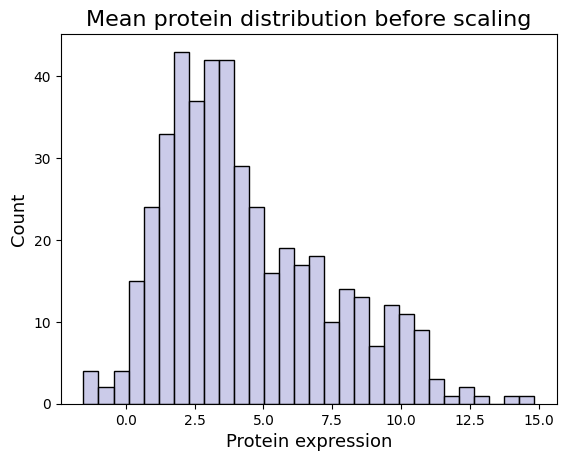

In [29]:
df_hist = df_impute.mean(axis = 0)
sns.histplot(df_hist, bins = 30,color='#BABAE2',edgecolor="k") 

#The mean value for each metabolite has been plotted
plt.title('Mean protein distribution before scaling',fontsize=16)
plt.xlabel('Protein expression',fontsize=13)
plt.ylabel('Count',fontsize=13) 

#plt.savefig( 'Figures/prescale_mean_protein_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

Text(0, 0.5, 'Count')

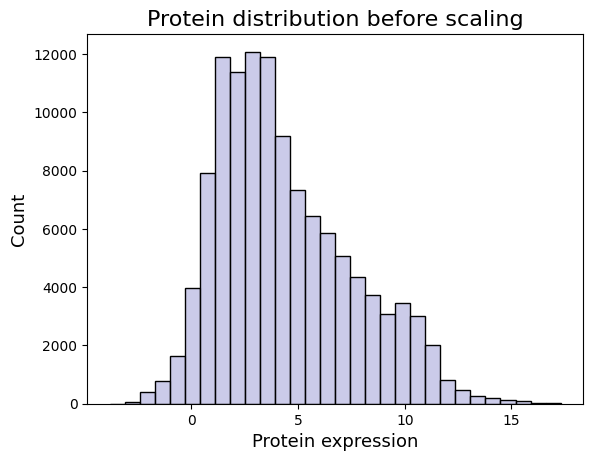

In [30]:
df_impute_np = df_impute.to_numpy()
df_hist = df_impute_np.flatten()
sns.histplot(df_hist, bins = 30,color='#BABAE2',edgecolor="k") 

#The mean value for each metabolite has been plotted
plt.title('Protein distribution before scaling',fontsize=16)
plt.xlabel('Protein expression',fontsize=13)
plt.ylabel('Count',fontsize=13) 

#plt.savefig( 'Figures/prescale_protein_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [42]:
#I decided not to use because too stringent (>20 outliers detected)

# Carry out PCA to identify outliers  
#https://towardsdatascience.com/outlier-detection-using-principal-component-analysis-and-hotellings-t2-and-spe-dmodx-methods-625b3c90897

#from pca import pca

# Initialize pca to also detected outliers
#model = pca(normalize=True, detect_outliers=['ht2', 'spe'], n_std=2  )

# Fit and transform
#results = model.fit_transform(df_impute)

# Get the outliers using Hotellings T2 method
#df_impute.loc[results['outliers']['y_bool'], :]

# Get the outliers using SPE/DmodX method
#df_impute.loc[results['outliers']['y_bool_spe'], :]

In [31]:
#Conduct PCA to identify outliers

features = df_impute.columns[:]
x = df_impute.loc[:, features].values

pca = PCA(n_components=20) 
principal_components = pca.fit_transform(x)


0.8019752016955461


Text(0, 0.5, 'Variance Explained')

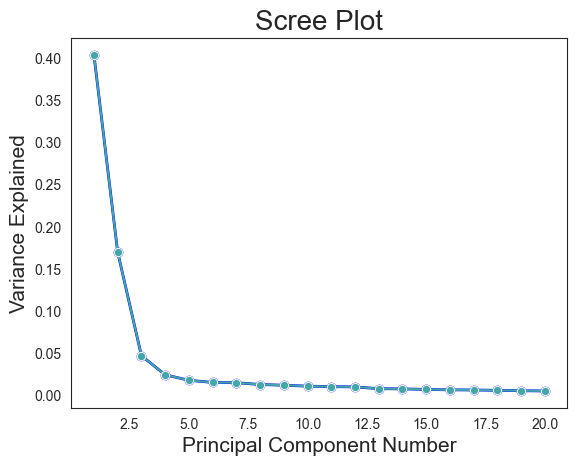

In [33]:
#Use elbow method for scree plot to determine number of PCs to use to calculate residuals (4 principal components)
print(sum(pca.explained_variance_ratio_))
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')


sns.set_style("white")
sns.lineplot(x=PC_values, y=pca.explained_variance_ratio_,  color='#42A7A9',marker="o")   # marker="o" shows markers as dots
plt.title('Scree Plot',fontsize=20)
plt.xlabel('Principal Component Number',fontsize=15)
plt.ylabel('Variance Explained',fontsize=15)

#plt.savefig( 'Figures/Scree_plot_protein_QC.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


### Individual residual variance method to identify outliers

In [44]:
#Conduct PCA to identify outliers

features = df_impute.columns[:]
x = df_impute.loc[:, features].values

pca = PCA(n_components=4) #determined using scree plot in the above cell
principal_components = pca.fit_transform(x)



#Calculate residuals to identify outliers
#Formula is:     Residuals = Data matrix - (PCA scores * PCA loadings)  https://datascience.stackexchange.com/questions/29132/how-can-i-extract-the-residual-array-from-the-scikit-learn-pca-routine

#Obtain PCA loadings (https://stackoverflow.com/questions/21217710/factor-loadings-using-sklearn)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

residuals = df_impute - principal_components.dot(loadings.transpose())
display(residuals)

#Calculate individual residual variance by taking the Euclidean norm (L2 norm) of values for each sample
#https://stackoverflow.com/questions/7741878/how-to-apply-numpy-linalg-norm-to-each-row-of-a-matrix
l2_norm = pd.DataFrame(np.linalg.norm(residuals,axis=1),columns = ['Individual residual variance'], index = df.index)
l2_norm_unordered = l2_norm.copy()
l2_norm = l2_norm.sort_values(['Individual residual variance'], ascending=[False])
display(l2_norm[:10])

#Top 10 outliers
outliers = list(l2_norm[:10].index.values)



,"lectin, galactoside-binding, soluble, 9","tumor necrosis factor receptor superfamily, member 10a",agouti related protein homolog (mouse),"tumor necrosis factor receptor superfamily, member 10b","tumor necrosis factor receptor superfamily, member 13B",c-fos induced growth factor (vascular endothelial growth factor D),dickkopf WNT signaling pathway inhibitor 1,renin,platelet-derived growth factor beta polypeptide,growth hormone 1,...,"EGF-like-domain, multiple 7",REST corepressor 1,carbonic anhydrase XIV,syntaxin 8,"protein kinase, AMP-activated, beta 1 non-catalytic subunit",mitogen-activated protein kinase kinase kinase kinase 5,negative regulator of ubiquitin-like proteins 1,ectonucleoside triphosphate diphosphohydrolase 2,"melanoma antigen family D, 1",G protein-coupled receptor 56
sample_id,,,,,,,,,,,,,,,,,,,,,
1010823,14.582193,8.992091,7.332949,12.211035,11.611819,6.362457,12.348120,10.440688,11.314758,12.640187,...,8.343070,5.862906,-2.107931,4.412275,3.014400,9.077295,4.049909,1.503614,2.672790,5.238853
1027114,43.830560,30.583679,36.318653,41.024253,34.657028,29.281542,55.602164,35.326248,54.349494,42.817599,...,25.140367,25.789459,-2.423184,45.485960,33.539958,67.168941,38.876893,11.235361,27.873116,22.678177
1029090,15.580831,8.713314,8.620921,11.846373,12.068418,7.641805,16.084273,10.487982,15.313357,10.898582,...,9.989387,8.841377,-1.032153,12.503285,9.832230,18.876095,12.560997,2.376770,7.122615,4.822174
1049423,17.460805,10.695454,11.082754,14.698697,16.055341,7.963616,19.031305,13.437127,16.892637,8.694186,...,11.335269,11.071421,-0.840506,15.895375,12.454031,23.251944,15.524337,3.486023,9.934871,6.430015
1057525,16.389747,10.369985,11.389104,14.094130,13.474475,8.397938,17.888685,12.460833,16.563397,10.937797,...,11.663075,10.146749,-0.307071,14.154249,10.983942,21.018752,13.101673,3.179631,8.290453,6.841731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV139,3.770602,-1.333366,-3.605757,0.171928,6.252768,7.879328,-5.974864,3.879469,-1.553086,14.098806,...,-4.108385,-11.385465,0.829236,-25.949464,-23.718484,-32.506284,-29.172208,-2.840695,-17.866327,-2.907278
INCOV141,7.832253,2.910467,2.203945,5.621623,8.826513,9.511210,1.485530,7.777130,3.533362,13.279561,...,1.218208,-4.797210,3.526519,-12.731874,-12.738880,-17.025318,-16.136406,0.432598,-9.907228,1.832270
INCOV142,2.118679,-4.484865,1.008184,-2.072270,8.018919,10.950761,2.851553,4.873774,7.822710,4.561265,...,-1.679553,-7.367402,8.237876,-7.707358,-8.875070,-10.997858,-11.883418,0.320108,-11.295197,-1.263544


,Individual residual variance
sample_id,
1027114,629.750380
1347882,490.417819
1552698,467.091933
1481374,463.001272
1874590,449.520548
1783121,414.257849
1288022,413.308955
1513501,405.279897
INCOV064,385.223634


Text(240, 190, 'Mean')

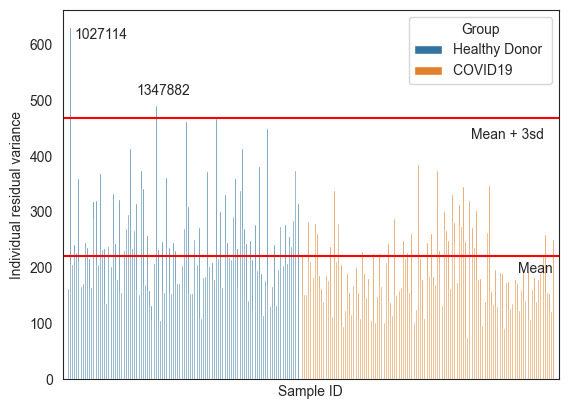

In [36]:
#Preparing data for bar graph 
l2_norm_unordered['Sample ID'] = l2_norm_unordered.index
l2_norm_unordered = pd.concat([l2_norm_unordered, meta_data], axis = 1)
l2_mean = l2_norm_unordered['Individual residual variance'].mean()
l2_std = l2_norm_unordered['Individual residual variance'].std()


#Bar graph showing individual residual variance with mean/median line
g = sns.barplot(data=l2_norm_unordered,x="Sample ID", y="Individual residual variance",hue='Group',width=2)

g2 = g.axes
g2.set(xticklabels=[],xticks=[]) 
g2.axhline(l2_mean,color='r') #plot mean
g2.axhline(l2_mean +(l2_std*3),color='r') #plot 3 standard deviations away from the mean
g2.margins(x=0.01) #increase space between first and last bar and the edges 

#Add labels for outliers
g2.text(3,610,"1027114")
g2.text(36,510,"1347882")
g2.text(215,430,"Mean + 3sd")
g2.text(240,190,"Mean")  

#plt.savefig( 'Figures/individual_residual_variance.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


### Counting number of outliers outside of mean plus/minus 3 standard deviations

In [37]:
#Outlier detection step - Z-score method
#The outliers should be removed before scaling
df_norm = pd.DataFrame(StandardScaler().fit_transform(df_impute),columns=df_impute.columns, index=df_impute.index)

df_norm = df_norm.to_numpy()
outlier_count = np.sum((df_norm > 3) | (df_norm < -3),axis=1)
outlier_df = pd.DataFrame(outlier_count, index = meta_data.index, columns = ['Outlier number'])
outlier_df = outlier_df.sort_values(['Outlier number'], ascending=[False])
display(outlier_df[:10]) #Outliers 3 std above the mean (first 3)

outlier_df['Outlier number'].mean()  #3.8108
outlier_df['Outlier number'].std()  #12.17


,Outlier number
sample_id,
INCOV064,149
INCOV090,81
1027114,76
INCOV028,40
INCOV072,26
INCOV139,23
1552698,22
INCOV020,22
INCOV008,19


12.16611919704808

### Identifying outliers using pair plot method

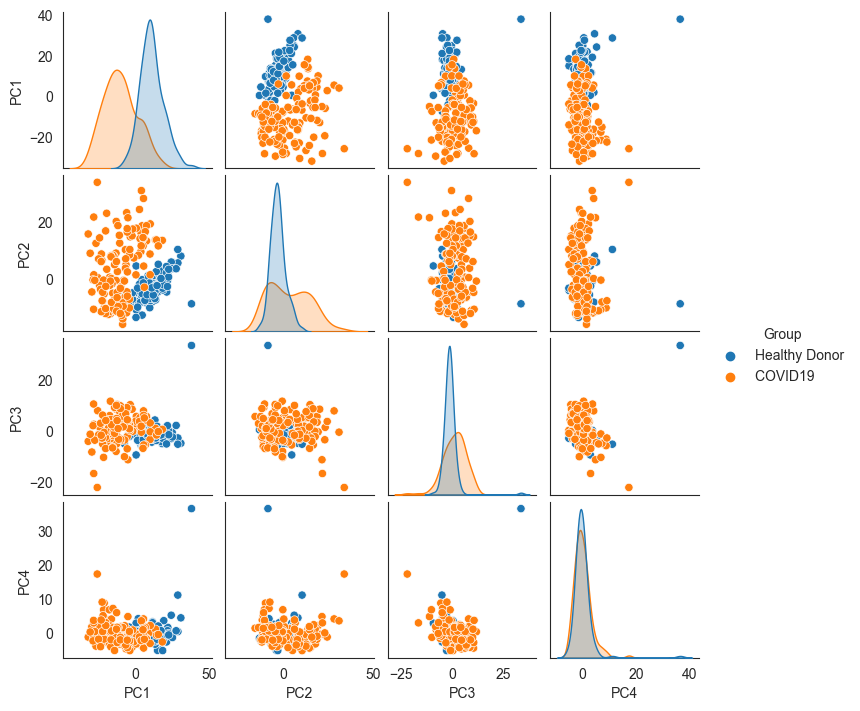

In [39]:
#Pair plots for first 4 principal components
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2','PC3', 'PC4'], index = df.index)

#Concatenate WHO information
df3 = pd.concat([df2, meta_data], axis = 1)
#display(df3)

sns.pairplot(df3, hue='Group',height=1.8)   

#plt.savefig( 'Figures/outlier_pairplot.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


In [41]:
#Alternatively, can dentify outliers by looking at which points are at the extremes of the PC axes and checking with the PCA plot
outliers_pc = df3.sort_values(['PC4'], ascending=[False])
display(outliers_pc.iloc[:10,:])

,PC1,PC2,PC3,PC4,WHO_status,Group
sample_id,,,,,,
1027114,37.964608,-8.795076,33.704754,36.562559,0,Healthy Donor
INCOV064,-25.666732,33.871070,-21.968068,17.387572,5-7,COVID19
1552698,28.714517,10.292613,-5.002746,11.213804,0,Healthy Donor
INCOV139,-22.375333,-7.716609,-2.558332,9.157798,3-4,COVID19
INCOV056,-21.005692,-10.214906,-5.578100,8.859612,1-2,COVID19
INCOV067,-15.039053,-8.163516,-4.668039,7.306334,1-2,COVID19
INCOV058,-21.386879,-0.463647,-10.161344,6.925532,1-2,COVID19
INCOV066,-17.522239,-10.835470,-0.984848,6.898507,1-2,COVID19
INCOV074,-12.583873,-11.238466,-4.891913,6.063224,1-2,COVID19


### Visualising outliers with first 2 principal components

In [45]:
#PCA for visualisation WITH FIRST 2 PRINCIPAL COMPONENTS AND OUTLIERS LABELLED
features = df_impute.columns[:]
x = df_impute.loc[:, features].values

pca = PCA(n_components=2) #two principal components for data visualisation
principal_components = pca.fit_transform(x)

df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'], index = df.index)

#Concatenate WHO information
df3 = pd.concat([df2, meta_data], axis = 1)

display(df3)

#Subset outlier dataframe to plot outliers
outlier_df = df3[df3.index.isin(outliers)]



,PC1,PC2,WHO_status,Group
sample_id,,,,
1010823,3.615214,-6.817582,0,Healthy Donor
1027114,37.964608,-8.795076,0,Healthy Donor
1029090,8.443286,-3.006131,0,Healthy Donor
1049423,11.254868,-3.631294,0,Healthy Donor
1057525,10.038930,-3.763232,0,Healthy Donor
...,...,...,...,...
INCOV139,-22.375333,-7.716609,3-4,COVID19
INCOV141,-12.261884,-6.595609,1-2,COVID19
INCOV142,-12.712771,6.027203,5-7,COVID19


In [46]:
outlier_df

,PC1,PC2,WHO_status,Group
sample_id,,,,
1027114,37.964608,-8.795076,0,Healthy Donor
1288022,24.887947,5.799629,0,Healthy Donor
1347882,30.777936,7.976925,0,Healthy Donor
1481374,28.787684,5.558451,0,Healthy Donor
1513501,24.275939,5.873236,0,Healthy Donor
1552698,28.714517,10.292613,0,Healthy Donor
1783121,25.115775,3.584180,0,Healthy Donor
1874590,27.600078,3.532082,0,Healthy Donor
1994373,22.592378,3.336809,0,Healthy Donor


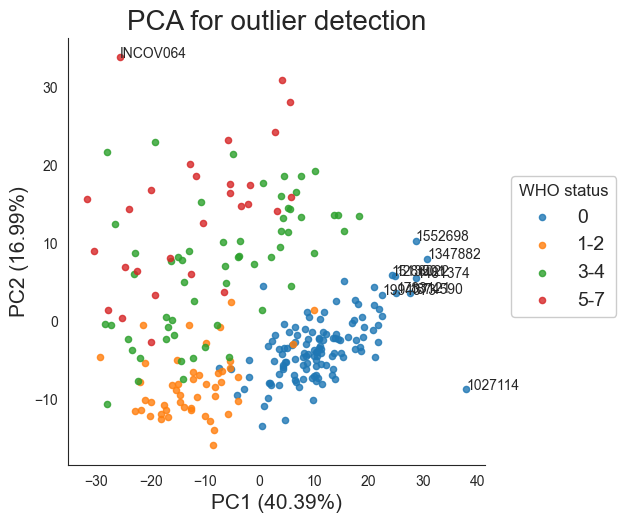

In [47]:

sns.set_style("white")

sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df3, 
    hue='WHO_status', 
    hue_order = ['0', '1-2', '3-4','5-7'],
    fit_reg=False, 
    legend=False,
    scatter_kws={"s": 20}
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend

for index,outlier in (enumerate(outliers)):
    plt.text(df3.PC1[outlier],df3.PC2[outlier], outlier)


plt.title('PCA for outlier detection',fontsize=20)
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=15)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=15)
plt.legend(framealpha=1, frameon = 'True', title="WHO status",title_fontsize='large', prop={'size': 14}, bbox_to_anchor=(1.04, 0.7)) 
#This has more information on the bbox_to_anchor coordinates: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot

#plt.savefig( 'Figures/PCA_protein_QC.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


### Removal of outliers prior to scaling

In [48]:
#Remove outlier 1027114
df_impute2 = df_impute.drop(1027114)
meta_data = meta_data.drop(1027114)


In [49]:
#Normalise by column i.e. each pathway is normalised across all patients
#mean of the observed values becomes 0 and the standard deviation is 1


df_norm = pd.DataFrame(StandardScaler().fit_transform(df_impute2),columns=df_impute2.columns, index=df_impute2.index)

print(df_norm.max().max())
print(df_norm.min().min())
print(df_norm.mean(axis = 0)) #mean of 0  
print(df_norm.std(axis = 0)) #sd of 1


10.9822604413013
-9.506183139855432
lectin, galactoside-binding, soluble, 9                    5.508083e-16
tumor necrosis factor receptor superfamily, member 10a     1.101617e-16
agouti related protein homolog (mouse)                     2.203233e-16
tumor necrosis factor receptor superfamily, member 10b    -4.957275e-16
tumor necrosis factor receptor superfamily, member 13B     1.239319e-15
                                                               ...     
mitogen-activated protein kinase kinase kinase kinase 5   -4.406467e-16
negative regulator of ubiquitin-like proteins 1            2.203233e-16
ectonucleoside triphosphate diphosphohydrolase 2           1.101617e-16
melanoma antigen family D, 1                               1.101617e-16
G protein-coupled receptor 56                              5.508083e-17
Length: 454, dtype: float64
lectin, galactoside-binding, soluble, 9                    1.001944
tumor necrosis factor receptor superfamily, member 10a     1.001944
agouti r

In [50]:
#One feature has a lower mean than the others (superoxide dismutase 2, mitochondrial)
mean = pd.DataFrame(df_norm.mean(axis = 0))
mean[[0]].idxmin()

0    superoxide dismutase 2, mitochondrial
dtype: object

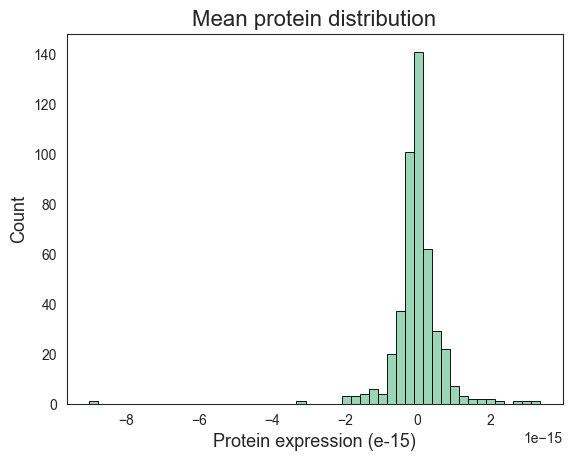

In [51]:
df_hist = df_norm.mean(axis = 0)
sns.histplot(df_hist, bins = 50,color='#79C99E',edgecolor="k") 

#The mean value for each metabolite has been plotted
plt.title('Mean protein distribution',fontsize=16)
plt.xlabel('Protein expression (e-15)',fontsize=13)
plt.ylabel('Count',fontsize=13) ;

#plt.savefig( 'Figures/mean_protein_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

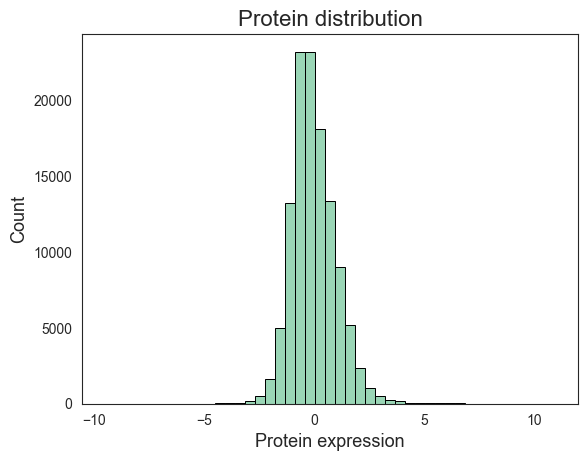

In [52]:

df_norm_np = df_norm.to_numpy()

df_hist = df_norm_np.flatten()
sns.histplot(df_hist, bins = 45,color='#79C99E',edgecolor="k") 

#The mean value for each metabolite has been plotted
plt.title('Protein distribution',fontsize=16)
plt.xlabel('Protein expression',fontsize=13)
plt.ylabel('Count',fontsize=13) ;

#plt.savefig( 'Figures/protein_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

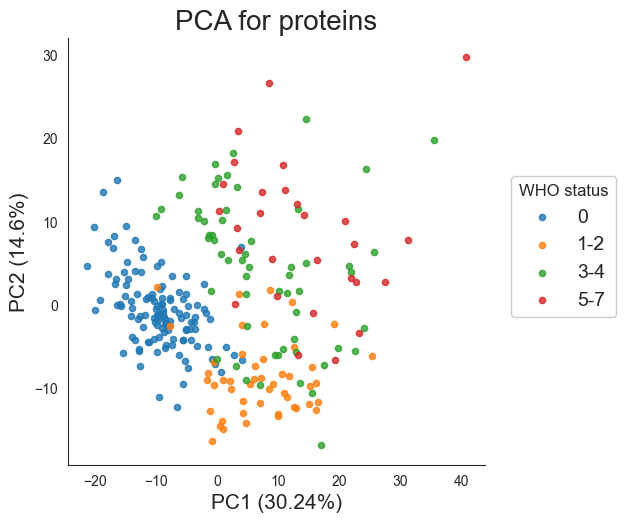

In [53]:
#Carry out PCA

features = df_norm.columns[:]
x = df_norm.loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(df_norm.index)

#Concatenate WHO information
df3 = pd.concat([df2, meta_data], axis = 1)

#display(df3)




sns.set_style("white")


sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df3, 
    hue='WHO_status', 
    hue_order = ['0', '1-2', '3-4','5-7'],
    fit_reg=False, #don't draw line of best fit
    legend=False,
    scatter_kws={"s": 20}
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend


plt.title('PCA for proteins',fontsize=20)
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=15,)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=15)
plt.legend(framealpha=1, frameon = 'True', title="WHO status",title_fontsize='large', prop={'size': 14}, bbox_to_anchor=(1.04, 0.7)) 

#plt.savefig( 'Figures/proteins_PCA.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


       

In [54]:
#Add metadata to the end of the df
df_final = pd.concat([df_norm, meta_data],axis=1) 
#df_final.to_csv('Data/Su_COVID_proteomics_processed_names.csv')

### Convert protein columns from names to UniProt IDs

In [56]:
#Convert protein columns from names to Uniprot IDs 

#Read in pre-processed dataframe
df = pd.read_csv('Data/Su_COVID_proteomics_processed_names.csv', index_col=0)

#Read in the conversion table
conversion_tab = pd.read_csv('Data/proteomics_metadata.csv', index_col=0)


In [57]:
#Separate dataframe into numerical data and meta data
meta_data = df.iloc[:,-2:]
df = df.iloc[:,:-2]

In [58]:
#Subset conversion table to only the proteins present in the data
protein_names = list(df.columns)
conversion_tab2 = conversion_tab[conversion_tab['gene_description'].isin(protein_names)]


In [59]:
conversion_tab2 = conversion_tab2.sort_values(by='gene_description')

#Check duplicates in the gene description column have the same Uniprot IDs (they do)
conversion_tab2 = conversion_tab2.drop_duplicates(subset='uniprot')
conversion_tab2 = conversion_tab2.reset_index(drop=True)

from collections import Counter
mylist = conversion_tab2.gene_description

dups = [k for k,v in Counter(mylist).items() if v>1]
print(dups)



[]


In [60]:
df_uniprot = df.rename(columns=dict(zip(conversion_tab2["gene_description"], conversion_tab2["uniprot"])))

In [61]:
#Add metadata to the end of the df
df_final = pd.concat([df_uniprot, meta_data],axis=1) 
#df_final.to_csv('Data/Su_COVID_proteomics_processed.csv')